<a href="https://colab.research.google.com/github/lnsayer/personal_repo/blob/main/drug%20discovery%20with%20BACE%20dataset/graph_classification_bace_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary packages
!pip install rdkit
!pip install torch_geometric
!pip install deepchem
!pip install networkx
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 9.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.wh

In [2]:
# Import necessary modules
import requests
from pathlib import Path
import os.path as osp

from rdkit import Chem
from rdkit.Chem import Draw

import torch
import torch_geometric
from torch_geometric.data import InMemoryDataset, Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, GraphConv, GATConv, MLP, GINConv, global_max_pool, SAGPooling, TopKPooling, GINEConv
from torch.nn import Linear, ReLU, Dropout, Softmax
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import BinaryAUROC, BinaryPrecision, BinaryRecall


import deepchem as dc
from deepchem.feat.graph_data import GraphData

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pandas import DataFrame

import networkx as nx

import random

from tqdm.auto import tqdm

from IPython.display import Javascript

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [82]:
import os
google_drive_path = Path("drive/MyDrive")
for dirpath, dirnames, filenames in os.walk(google_drive_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 8 directories and 27 images in 'drive/MyDrive'.
There are 3 directories and 103 images in 'drive/MyDrive/Peru 2019 Expedition'.
There are 1 directories and 0 images in 'drive/MyDrive/Peru 2019 Expedition/Alex's Photos'.
There are 0 directories and 418 images in 'drive/MyDrive/Peru 2019 Expedition/Alex's Photos/Peru 2019'.
There are 0 directories and 0 images in 'drive/MyDrive/Peru 2019 Expedition/Emilie'.
There are 0 directories and 0 images in 'drive/MyDrive/Peru 2019 Expedition/Groña'.
There are 0 directories and 2 images in 'drive/MyDrive/Private'.
There are 0 directories and 50 images in 'drive/MyDrive/Old phone photos'.
There are 0 directories and 37 images in 'drive/MyDrive/Go_pro_gorge_du_verdon_2016'.
There are 0 directories and 30 images in 'drive/MyDrive/Colab Notebooks'.
There are 0 directories and 21 images in 'drive/MyDrive/Uni textbook photos '.
There are 0 directories and 6 images in 'drive/MyDrive/udemy_ml_course_data'.


In [86]:
bace_project_path = google_drive_path / "bace_graph_project"
bace_raw_path = bace_project_path / "data/raw"

<class 'pathlib.PosixPath'>


In [90]:
# Check if Bace csv file has been downloaded, if not, download it
if bace_raw_path.is_dir():
  print(f"{bace_raw_path} is already a directory")
else:
  print(f"{bace_raw_path} is not a directory, creating one")
  bace_raw_path.mkdir(parents=True, exist_ok=True)

  with open(bace_raw_path / "bace.csv", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/lnsayer/personal_repo/main/drug%20discovery%20with%20BACE%20dataset/data/bace.csv")
    print("Downloading data")
    f.write(request.content)

drive/MyDrive/bace_graph_project/data/raw is already a directory


In [5]:
# Turn CSV file into a dataframe and resave it without unnecessary columns
bace_df = pd.read_csv(bace_path/ "bace.csv")
bace_df = bace_df[["mol", "CID", "Class", "Model", "pIC50"]]
bace_df.to_csv(bace_path/"bace.csv")

bace_df

,mol,CID,Class,Model,pIC50
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970
...,...,...,...,...,...
1508,Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N,BACE_1543,0,Test,3.000000
1509,Clc1cc2nc(n(c2cc1)C(CC(=O)NCc1ncccc1)CC)N,BACE_1544,0,Test,3.000000
1510,Brc1cc(ccc1)C1CC1C=1N=C(N)N(C)C(=O)C=1,BACE_1545,0,Test,2.953115
1511,O=C1N(C)C(=NC(=C1)C1CC1c1cc(ccc1)-c1ccccc1)N,BACE_1546,0,Test,2.733298


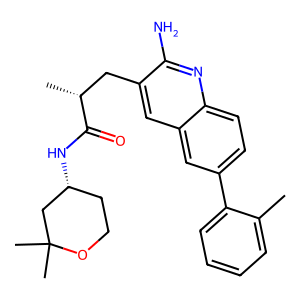

In [6]:
# Visualise one of the molecules from its SMILE input
inhibitor = bace_df["mol"][0]

m = Chem.MolFromSmiles(inhibitor)

img = Draw.MolToImage(m)

display(img)

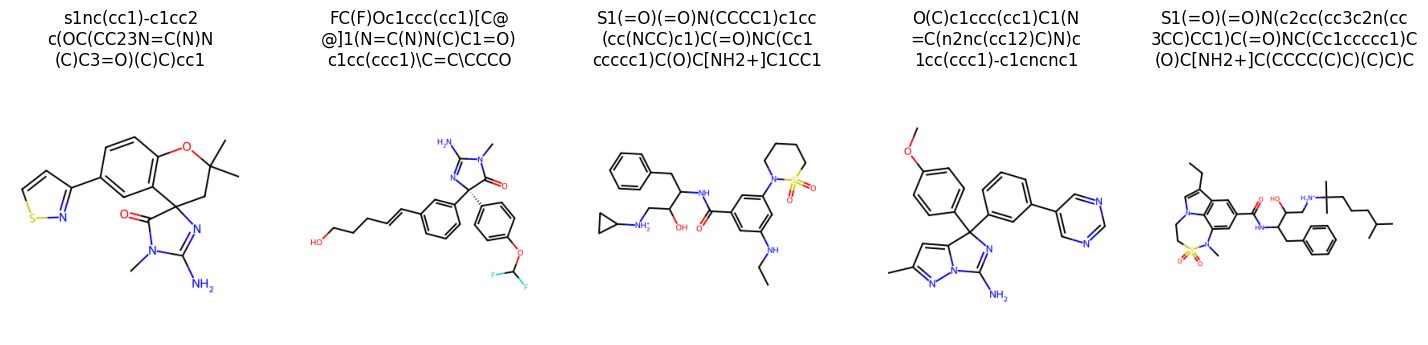

In [7]:
# Display five random molecules with their SMILES molecules

# Create axes and sample SMILES molecules
fig, ax = plt.subplots(ncols=5, nrows=1, figsize = (18,6))
mols = bace_df.sample(n=5, random_state=42)["mol"]

for i in range(len(mols)):

  # Convert each molecule to an image
  mol = mols.iloc[i]
  m = Chem.MolFromSmiles(mol)
  img = Draw.MolToImage(m)

  # Plot each molecule
  ax[i].imshow(img)
  ax[i].axis(False);

  # Divide the SMILE input into three parts
  first_part = mol[:int(len(mol)/3)]
  second_part = mol[int(len(mol)//3):int(2*len(mol)//3)]
  third_part = mol[int(2*len(mol)//3):]

  assert len(mol) == len(first_part)+len(second_part)+len(third_part)

  first_title = first_part + "\n"
  second_title = second_part + "\n"
  third_title = third_part + "\n"

  # Title each plot with its respective SMILE input
  ax[i].set_title(first_title+second_title+third_title)

In [8]:
# Test converting a molecule into a graph using MolGraphConvFeaturizer and to_pyg_graph

# Select first molecule
mol = bace_df["mol"][1]

# Instantiate MolGraphConvFeaturizer class
featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True)

# Convert SMILES molecule into a DeepChem graph
out = featurizer.featurize(datapoints=mol)

# Convert into torch geometric graph
pyg_out = GraphData.to_pyg_graph(out[0])
pyg_out.y = torch.tensor([bace_df["Class"][0]])

print(pyg_out)

Data(x=[47, 30], edge_index=[2, 100], edge_attr=[100, 11], y=[1])


In [9]:
# Custom torch geometric Dataset class to store the samples and their corresponding labels

class MoleculeDataset(Dataset):
  def __init__(self, root, csv_file, transform=None, pre_transform=None, pre_filter=None):
    """
    root = Where the dataset should be stored. This folder is split
    into raw_dir (downloaded dataset) and processed_dir(processed data).
    """
    self.csv_file = csv_file
    super().__init__(root, transform, pre_transform, pre_filter)

  @property
  def raw_file_names(self):
    """
    If this file exists in raw_dir, the download is not triggered/
    (the download function is not implemented here)
    """
    return self.csv_file

  @property
  def processed_file_names(self):
    """
    If these files are found in raw_dir, processing is skipped
    """
    self.data = pd.read_csv(self.raw_paths[0]).reset_index()

    return [f'data_{i}.pt' for i in list(self.data.index)]

  def download(self):
    """
    No need to download the csv file as it is already downloaded
    """
    pass

  def process(self):
    """
    I used Deepchem's MolGraphConvFeaturizer to create a graph and then convert that to a torch graph with to_pyg_graph.
    """
    self.data = pd.read_csv(self.raw_paths[0]).reset_index()
    featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True)

    for idx, row in self.data.iterrows():
      # Featurize molecule and convert to torch graph
      smiles = row['mol']
      label = row['Class']
      pic50 = row['pIC50']

      out = featurizer.featurize(smiles)
      pyg_out = GraphData.to_pyg_graph(out[0])
      pyg_out.Class = torch.tensor([label])
      pyg_out.smiles = smiles
      pyg_out.pic50 = pic50

      # data = Data(x=pyg_out.x, edge_index=pyg_out.edge_index, edge_attr=pyg_out.edge_attr,
      #            y=torch.tensor([label]), dtype = torch.float)

      torch.save(pyg_out, osp.join(self.processed_dir, f'data_{idx}.pt'))

  def len(self):
    """
    Returns number of samples in the dataset
    """
    return len(self.processed_file_names)

  def get(self, idx):
    """
    Loads a single graph
    """
    data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
    return data

In [10]:
# Instantiate the dataset from the BACE CSV file

original_dataset = MoleculeDataset(root = "drive/MyDrive/bace_graph_project/data/", csv_file = "bace.csv").shuffle()dataset = original_dataset

train_indices = int(0.8*len(dataset))

train_dataset = dataset[:train_indices]
test_dataset = dataset[train_indices:]


print(f"Total dataset samples: {len(dataset)}\nTrain dataset samples: {len(train_dataset)}\nTest dataset samples: {len(test_dataset)}")

Processing...


Total dataset samples: 1513
Train dataset samples: 1210
Test dataset samples: 303


Done!


In [11]:
# Calculate average nodes and edges in the graphs
avg_nodes = 0
avg_edges = 0
for i in range(len(original_dataset)):
  avg_nodes+=original_dataset[i].x.shape[0]/len(original_dataset)
  avg_edges+=original_dataset[i].edge_index.shape[1]/len(original_dataset)
print(f"avg nodes: {avg_nodes:.4f}, avg_edges: {avg_edges:.4f}")



avg nodes: 34.0892, avg_edges: 73.7184


In [12]:
# Create a dataloader from the dataset
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"Number of batches: {len(train_dataloader)}")
print(f"Number of samples: {len(train_dataset)}")

Number of batches: 38
Number of samples: 1210


In [13]:
# Load a single graph

print(f"Number of nodes in graph is: {train_dataset[0].x.shape[0]}")
print(f"Number of features for each node is {train_dataset[0].num_features}")
print(f"Number of edges is {train_dataset[0].edge_index.shape[1]}")
print(f"Data object is {train_dataset[0]}\n")

Number of nodes in graph is: 37
Number of features for each node is 30
Number of edges is 80
Data object is Data(x=[37, 30], edge_index=[2, 80], edge_attr=[80, 11], Class=[1], smiles='S1(=O)(=O)N(c2cc(cc3n(cc(CC1)c23)CC)C(=O)NC([C@H](O)C[NH2+]CC(F)F)Cc1ccccc1)C', pic50=7.6989698)



In [14]:
# Node features for one the graphs. This class is a featurizer of general graph convolution networks for molecules.
# The default node(atom) and edge(bond) representations are based on WeaveNet paper.

# train_dataset[0].x

In [15]:
# See the format for a batch
print(next(iter(train_dataloader)))

DataBatch(x=[1086, 30], edge_index=[2, 2362], edge_attr=[2362, 11], Class=[32], smiles=[32], pic50=[32], batch=[1086], ptr=[33])


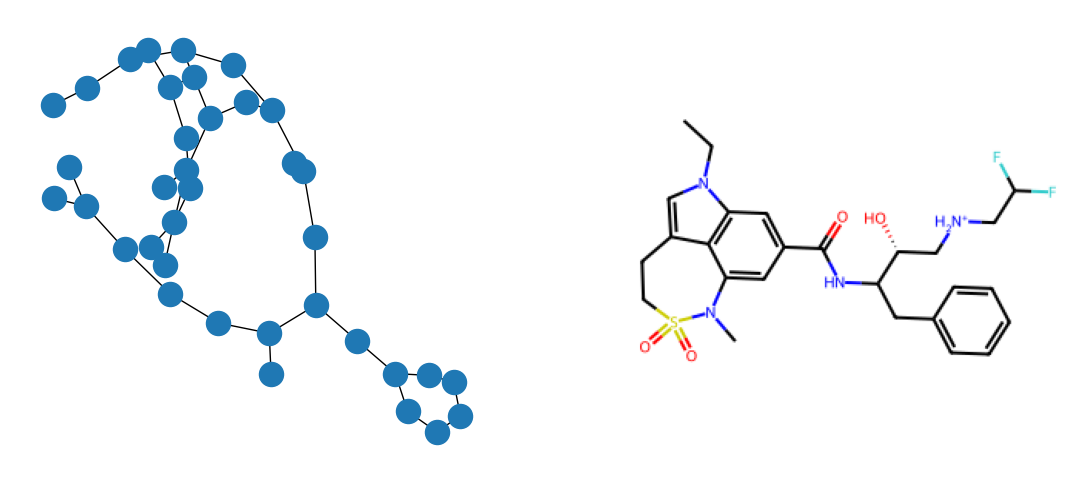

In [16]:
np.random.seed(44)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (14,6))

g = torch_geometric.utils.to_networkx(train_dataset[0], to_undirected=True)
nx.draw(g, ax = ax[0])

mol = dataset[0].smiles
m = Chem.MolFromSmiles(mol)
img = Draw.MolToImage(m)

ax[1].imshow(img)
ax[1].axis(False);

In [17]:
# Print 5 batches
i = 0
for batch in train_dataloader:
  while i <5:
    print(batch)
    i+=1

DataBatch(x=[1059, 30], edge_index=[2, 2294], edge_attr=[2294, 11], Class=[32], smiles=[32], pic50=[32], batch=[1059], ptr=[33])
DataBatch(x=[1059, 30], edge_index=[2, 2294], edge_attr=[2294, 11], Class=[32], smiles=[32], pic50=[32], batch=[1059], ptr=[33])
DataBatch(x=[1059, 30], edge_index=[2, 2294], edge_attr=[2294, 11], Class=[32], smiles=[32], pic50=[32], batch=[1059], ptr=[33])
DataBatch(x=[1059, 30], edge_index=[2, 2294], edge_attr=[2294, 11], Class=[32], smiles=[32], pic50=[32], batch=[1059], ptr=[33])
DataBatch(x=[1059, 30], edge_index=[2, 2294], edge_attr=[2294, 11], Class=[32], smiles=[32], pic50=[32], batch=[1059], ptr=[33])


In [18]:
# Create tensor of the average of the node features for all 1210 training samples
a = torch.tensor(())
for idx, data in enumerate(train_dataloader):
  x = global_mean_pool(data.x, data.batch)
  a = torch.cat((a, x), 0)


In [19]:
print(a.shape)
df = pd.DataFrame(a.numpy())
# display(df)
corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')

torch.Size([1210, 30])


In [20]:
class GCNClassifier(torch.nn.Module):
  """
  Standard GCN graph classifier
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int, pool_method:torch_geometric.nn.pool):
    super().__init__()
    # Convolutional Layers
    self.conv1 = GCNConv(in_channels, hidden_channels)

    self.conv2 = GCNConv(hidden_channels, hidden_channels)

    self.conv3 = GCNConv(hidden_channels, hidden_channels)

    # Linear layer used in classification
    self.lin = Linear(hidden_channels, out_channels)

  def forward(self, data):
    # Obtain node embeddings
    x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

    x = self.conv1(x, edge_index)
    x = F.leaky_relu(x)
    x = self.conv2(x, edge_index)
    x = F.leaky_relu(x)
    x = self.conv3(x, edge_index)

    # Aggregate node embeddings
    x = pool_method(x, batch)

    # Regularisation
    x = F.dropout(x)

    # Classification
    x = self.lin(x)

    x = F.softmax(x, dim=1)

    return x

GCNClassifier(7, 64, 2, global_mean_pool)

GCNClassifier(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [21]:
class GraphConvClassifier(GCNClassifier):
  """
  Same architecture as GCN Classifier however use GraphConv layers
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int,  pool_method:torch_geometric.nn.pool):
    super().__init__(in_channels, hidden_channels, out_channels, pool_method)
    self.conv1 = GraphConv(in_channels, hidden_channels)

    self.conv2 = GraphConv(hidden_channels, hidden_channels)

    self.conv3 = GraphConv(hidden_channels, hidden_channels)
GraphConvClassifier(7, 64, 2, global_mean_pool)

GraphConvClassifier(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [22]:
class GATClassifier(torch.nn.Module):
  """
  GAT Convolutional graph classifier
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int, heads:int, pool_method:torch_geometric.nn.pool,
               use_edge_attr:bool):
    super().__init__()
    # Convolutional Layers
    self.conv1 = GATConv(in_channels,
                         hidden_channels,
                         heads,
                         concat = True)
    self.conv2 = GATConv(hidden_channels*heads,
                         hidden_channels,
                         heads,
                         concat=True)
    self.conv3 = GATConv(hidden_channels*heads,
                         hidden_channels,
                         1,
                         concat=False)
    self.lin = Linear(hidden_channels, out_channels)

  def forward(self, data):
    # Obtain node embeddings
    x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

    # can use edge attributes
    if use_edge_attr:
      x = self.conv1(x, edge_index, edge_attr)
      x = F.leaky_relu(x)
      x = self.conv2(x, edge_index, edge_attr)
      x = F.leaky_relu(x)
      x = self.conv3(x, edge_index, edge_attr)

    # not using edge attributes
    else:
      x = self.conv1(x, edge_index)
      x = F.leaky_relu(x)
      x = self.conv2(x, edge_index)
      x = F.leaky_relu(x)
      x = self.conv3(x, edge_index)

    # Aggregate node embeddings
    x = pool_method(x, batch)

    # Regularisation
    x = F.dropout(x)

    # Classification
    x = self.lin(x)

    x = F.softmax(x, dim=1)

    return x

GATClassifier(30, 64, 2, 8, global_max_pool, True)

GATClassifier(
  (conv1): GATConv(30, 64, heads=8)
  (conv2): GATConv(512, 64, heads=8)
  (conv3): GATConv(512, 64, heads=1)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [23]:
type(GINConv(nn))

torch_geometric.nn.conv.gin_conv.GINConv

In [24]:
class GINConvClassifier(torch.nn.Module):
  """
  Applies the graph isomorphism operator
  """
  def __init__(self, in_channels, hidden_channels, out_channels, num_layers, pool_method: torch_geometric.nn.pool):
    super().__init__()

    self.convs = torch.nn.ModuleList()
    self.conv = GINConv

    for _ in range(num_layers):
      mlp = MLP([in_channels, hidden_channels, hidden_channels])
      self.convs.append(self.conv(nn=mlp, train_eps=False))
      in_channels = hidden_channels

    self.mlp = MLP([hidden_channels, hidden_channels, out_channels], norm = None, dropout = 0.5)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    for conv in self.convs:
      x = conv(x, edge_index).relu()
    x = pool_method(x, batch)
    return self.mlp(x)

GINConvClassifier(30, 64, 2, 3, global_mean_pool)

GINConvClassifier(
  (convs): ModuleList(
    (0): GINConv(nn=MLP(30, 64, 64))
    (1-2): 2 x GINConv(nn=MLP(64, 64, 64))
  )
  (mlp): MLP(64, 64, 2)
)

In [58]:
mlp = MLP([30, 64, 64])

conv = GINEConv

print(conv(nn=mlp, train_eps=False))

GINEConv(nn=MLP(30, 64, 64))


In [73]:
class GINEConvClassifier(torch.nn.Module):
  """
  Applies the graph isomorphism operator
  """
  def __init__(self, in_channels, hidden_channels, out_channels, num_layers, pool_method: torch_geometric.nn.pool,
               use_edge_attr:bool, edge_dim:int):
    super().__init__()

    self.convs = torch.nn.ModuleList()
    self.conv = GINEConv
    self.use_edge_attr = use_edge_attr
    self.edge_dim = edge_dim

    for _ in range(num_layers):
      mlp = MLP([in_channels, hidden_channels, hidden_channels])
      self.convs.append(self.conv(nn=mlp, train_eps=False, edge_dim=self.edge_dim))
      in_channels = hidden_channels

    self.mlp = MLP([hidden_channels, hidden_channels, out_channels], norm = None, dropout = 0.5)

  def forward(self, data):
    x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr
    for conv in self.convs:
      if self.use_edge_attr:
        x = conv(x, edge_index, edge_attr).relu()
      else:
        x = conv(x, edge_index).relu()

    x = pool_method(x, batch)
    return self.mlp(x)

GINEConvClassifier(30, 64, 2, 3, global_mean_pool, True, dataset[0].edge_attr.shape[1])

GINEConvClassifier(
  (convs): ModuleList(
    (0): GINEConv(nn=MLP(30, 64, 64))
    (1-2): 2 x GINEConv(nn=MLP(64, 64, 64))
  )
  (mlp): MLP(64, 64, 2)
)

In [70]:
dataset[2].edge_attr.shape[1]

11

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  # Send model to device
  model.to(device)
  model.train()

  train_loss, train_acc = 0, 0

  # Loop over the batches
  for batch in dataloader:
    batch = batch.to(device)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Forward pass
    out = model(batch)

    # Calculate the loss
    loss = loss_fn(out, batch.Class)
    train_loss += loss.item()

    # Calculate the label predictions
    label_preds = torch.argmax(out, dim=1)
    # Calculate accuracy
    train_acc += (label_preds == batch.Class).sum()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss/len(dataloader.dataset)
  train_acc = train_acc/len(dataloader.dataset)

  return train_loss, train_acc

In [27]:
def test_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  # Put model in eval mode
  model.eval()

  test_loss, test_acc = 0, 0

  # Turn on torch inference manager
  with torch.inference_mode():
    # Loop through data batches
    for batch in dataloader:
      batch = batch.to(device)

      # Forward pass
      out = model(batch)

      # Calculate the loss
      loss = loss_fn(out, batch.Class)
      test_loss += loss.item()

      # Calculate the label predictions
      label_preds = torch.argmax(out, dim=1)
      # Calculate accuracy
      test_acc += (label_preds == batch.Class).sum()/len(label_preds)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)

    return test_loss, test_acc

In [28]:
# Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int = 5):

  # 2. Create empty results dictionary
  results = {"epoch": [],
             "train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  # 3. Loop through training and testing steps for a number of epochs
  for i in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model,
                                       train_dataloader,
                                       loss_fn,
                                       optimizer)
    test_loss, test_acc = test_step(model,
                                    test_dataloader,
                                    loss_fn,
                                    optimizer)
    # 4. Print out what's happening
    print(f"Epoch: {i}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")
    # 5. Update results dictionary
    results["epoch"].append(i)
    results["train_loss"].append(round(train_loss, 4))
    results["train_acc"].append(round(train_acc.item(), 4))
    results["test_loss"].append(round(test_loss, 4))
    results["test_acc"].append(round(test_acc.item(), 4))
   # 6. Return the filled results at the end of the epochs

  return results

In [99]:
print(f"bace_project path: {bace_project_path}")
bace_models_path = bace_project_path / "models"
print(f"bace_models_path: {bace_models_path}\n")


if bace_models_path.is_dir():
  print(f"{bace_models_path} is already a directory")
else:
  print(f"{bace_models_path} is not a directory, creating one")
  bace_models_path.mkdir(parents=True, exist_ok=True)

bace_project path: drive/MyDrive/bace_graph_project
bace_models_path: drive/MyDrive/bace_graph_project/models

drive/MyDrive/bace_graph_project/models is already a directory


In [105]:
# GCN Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 128
num_out_channels = 2
# with global mean pooling, best is around 100 epochs
nb_epochs = 10
pool_method = global_mean_pool

# Instantiating GCN Classifier
model = GCNClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
sgd_optimizer = torch.optim.SGD(model.parameters())
criterion = torch.nn.CrossEntropyLoss()



bace_gcn_models_path = bace_models_path / "gcn_models"


if bace_gcn_models_path.is_dir():
  print(f"{bace_gcn_models_path} is already a directory")
else:
  print(f"{bace_gcn_models_path} is not a directory, creating one")
  bace_gcn_models_path.mkdir(parents=True, exist_ok=True)

for i in range(5):


"""
results = train(model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)
"""


<IPython.core.display.Javascript object>

drive/MyDrive/bace_graph_project/models/gcn_models is already a directory


'\nresults = train(model,\n      train_dataloader,\n      test_dataloader,\n      adam_optimizer,\n      loss_fn = criterion,\n      epochs = nb_epochs)\n'

In [30]:
auroc_metric = BinaryAUROC(thresholds=None)


def metric_func(model, train_dataset, test_dataset):
  train_probs = torch.empty(len(train_dataset))
  train_preds = np.empty(len(train_dataset))
  train_labels = torch.empty(len(train_dataset))

  test_probs = torch.empty(len(test_dataset))
  test_preds = np.empty(len(test_dataset))
  test_labels = torch.empty(len(test_dataset))


  with torch.inference_mode():
    model.eval()
    for i in range(len(train_dataset)):
      train_probs[i] = model.forward(train_dataset[i].to(device)).cpu()[0][1].item()
      train_preds[i] = model.forward(train_dataset[i].to(device)).cpu().argmax().item()
      train_labels[i] = train_dataset[i].Class.item()
    for i in range(len(test_dataset)):
      test_probs[i] = model.forward(test_dataset[i].to(device)).cpu()[0][1].item()
      test_preds[i] = model.forward(test_dataset[i].to(device)).cpu().argmax().item()
      test_labels[i] = test_dataset[i].Class.item()

    train_auroc = auroc_metric(train_probs, train_labels).item()
    test_auroc = auroc_metric(test_probs, test_labels).item()

  train_classification_report = classification_report(train_labels, train_preds, output_dict=True)
  test_classification_report = classification_report(test_labels, test_preds, output_dict=True)

  train_report_df = pd.DataFrame(data=train_classification_report).transpose()
  test_report_df = pd.DataFrame(data=test_classification_report).transpose()

  return train_auroc, test_auroc, train_report_df, test_report_df

In [32]:
# train_auroc, test_auroc, train_report_df, test_report_df = metric_func(model, train_dataset, test_dataset)

In [33]:
def loss_and_acc_plots(results):

  fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (14,6))

  ax[0].plot(results["epoch"], results["train_loss"], label="Train");
  ax[0].plot(results["epoch"], results["test_loss"],  label="Test");

  ax[1].plot(results["epoch"], results["train_acc"], label="Train");
  ax[1].plot(results["epoch"], results["test_acc"],  label="Test");

  ax[0].set_xlabel("Epochs", size=14)
  ax[0].set_ylabel("Loss", size=14)

  ax[1].set_xlabel("Epochs", size=14)
  ax[1].set_ylabel("Accuracy", size=14)

  ax[0].legend();
  ax[1].legend();

In [35]:
# loss_and_acc_plots(results)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [36]:
# GAT Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 64
num_out_channels = 2
heads=4
# with no edge attributes, global mean pooling best is 70 epochs
nb_epochs = 70
use_edge_attr = True
pool_method = global_mean_pool

# Instantiating GAT Classifier
gat_model = GATClassifier(num_features, num_hidden_channels, num_out_channels, heads, pool_method, use_edge_attr)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.001, weight_decay=1e-4)
sgd_optimizer = torch.optim.SGD(gat_model.parameters())
criterion = torch.nn.CrossEntropyLoss()


gat_results = train(gat_model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)


<IPython.core.display.Javascript object>

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0216, Train acc: 0.5240, Test loss: 0.6968, Test acc: 0.5252
Epoch: 1, Train loss: 0.0215, Train acc: 0.5554, Test loss: 0.6862, Test acc: 0.5431
Epoch: 2, Train loss: 0.0210, Train acc: 0.6000, Test loss: 0.6818, Test acc: 0.5381
Epoch: 3, Train loss: 0.0206, Train acc: 0.6000, Test loss: 0.6643, Test acc: 0.6100
Epoch: 4, Train loss: 0.0206, Train acc: 0.5992, Test loss: 0.6558, Test acc: 0.6167
Epoch: 5, Train loss: 0.0204, Train acc: 0.6174, Test loss: 0.6616, Test acc: 0.6046
Epoch: 6, Train loss: 0.0200, Train acc: 0.6372, Test loss: 0.6570, Test acc: 0.5752
Epoch: 7, Train loss: 0.0198, Train acc: 0.6421, Test loss: 0.6510, Test acc: 0.5877
Epoch: 8, Train loss: 0.0198, Train acc: 0.6562, Test loss: 0.6329, Test acc: 0.6342
Epoch: 9, Train loss: 0.0194, Train acc: 0.6769, Test loss: 0.6218, Test acc: 0.6573
Epoch: 10, Train loss: 0.0191, Train acc: 0.6802, Test loss: 0.6134, Test acc: 0.6894
Epoch: 11, Train loss: 0.0190, Train acc: 0.6876, Test loss: 0.6

In [37]:
print(type(adam_optimizer))


<class 'torch.optim.adam.Adam'>


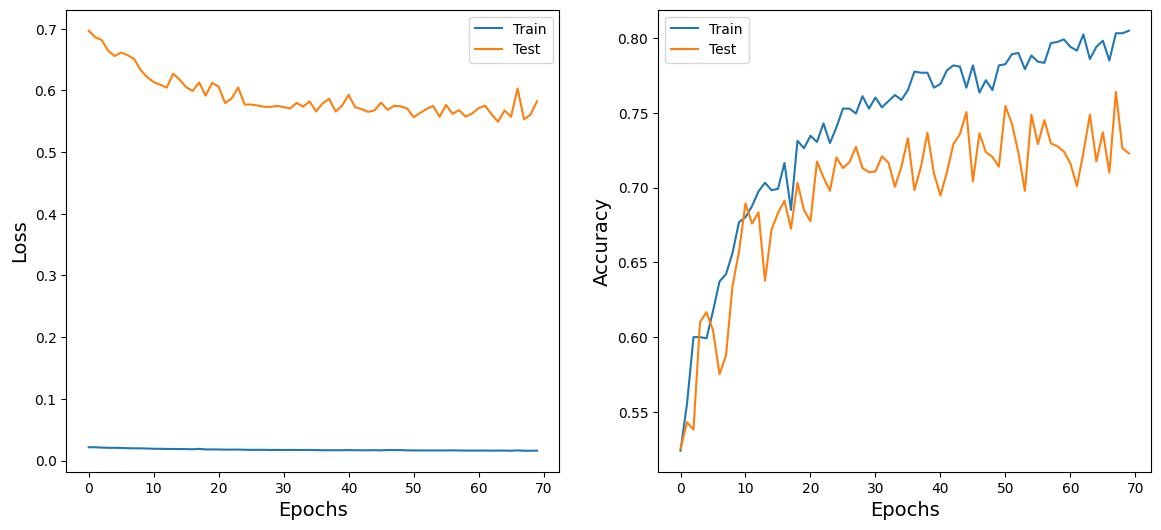

In [38]:
loss_and_acc_plots(gat_results)

In [39]:
# GraphConv Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 64
num_out_channels = 2
# global mean pooling, best is 50 epochs
nb_epochs = 50
pool_method = global_mean_pool

# Instantiating GAT Classifier
graphconv_model = GraphConvClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(graphconv_model.parameters(), lr=0.001, weight_decay=1e-4)
sgd_optimizer = torch.optim.SGD(graphconv_model.parameters())
criterion = torch.nn.CrossEntropyLoss()

"""
graphconv_results = train(graphconv_model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)
"""

<IPython.core.display.Javascript object>

'\ngraphconv_results = train(graphconv_model,\n      train_dataloader,\n      test_dataloader,\n      adam_optimizer,\n      loss_fn = criterion,\n      epochs = nb_epochs)\n'

In [41]:
# loss_and_acc_plots(graphconv_results)

In [53]:
# GINConv Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 64
num_out_channels = 2
num_layers = 3
nb_epochs = 50
pool_method = global_mean_pool

# Instantiating GINConv Classifier
ginconv_model = GINConvClassifier(num_features, num_hidden_channels, num_out_channels, num_layers, pool_method)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(ginconv_model.parameters(), lr=0.001, weight_decay=1e-4)
sgd_optimizer = torch.optim.SGD(ginconv_model.parameters())
criterion = torch.nn.CrossEntropyLoss()


ginconv_results = train(ginconv_model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)



<IPython.core.display.Javascript object>

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0208, Train acc: 0.5851, Test loss: 0.6335, Test acc: 0.5748
Epoch: 1, Train loss: 0.0183, Train acc: 0.7066, Test loss: 0.5871, Test acc: 0.7023
Epoch: 2, Train loss: 0.0165, Train acc: 0.7413, Test loss: 0.6090, Test acc: 0.6760
Epoch: 3, Train loss: 0.0158, Train acc: 0.7537, Test loss: 0.5774, Test acc: 0.7260
Epoch: 4, Train loss: 0.0154, Train acc: 0.7603, Test loss: 0.5120, Test acc: 0.7815
Epoch: 5, Train loss: 0.0147, Train acc: 0.7884, Test loss: 0.4843, Test acc: 0.7840
Epoch: 6, Train loss: 0.0145, Train acc: 0.7826, Test loss: 0.5132, Test acc: 0.7702
Epoch: 7, Train loss: 0.0142, Train acc: 0.7934, Test loss: 0.4622, Test acc: 0.8206


KeyboardInterrupt: 

In [44]:
# loss_and_acc_plots(ginconv_results)

In [77]:
# GINEConv Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 64
num_out_channels = 2
num_layers = 3
# best number of epochs with edge attributes is about 15
nb_epochs = 15
pool_method = global_mean_pool
use_edge_attr = True
edge_dim = dataset[0].edge_attr.shape[1]

# Instantiating GINEConv Classifier
gineconv_model = GINEConvClassifier(num_features, num_hidden_channels, num_out_channels, num_layers, pool_method, use_edge_attr, edge_dim)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(gineconv_model.parameters(), lr=0.001, weight_decay=1e-4)
sgd_optimizer = torch.optim.SGD(gineconv_model.parameters())
criterion = torch.nn.CrossEntropyLoss()


gineconv_results = train(gineconv_model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)


<IPython.core.display.Javascript object>

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.0210, Train acc: 0.5736, Test loss: 0.6533, Test acc: 0.5471
Epoch: 1, Train loss: 0.0184, Train acc: 0.6835, Test loss: 0.5398, Test acc: 0.7448
Epoch: 2, Train loss: 0.0169, Train acc: 0.7306, Test loss: 0.5363, Test acc: 0.7613
Epoch: 3, Train loss: 0.0156, Train acc: 0.7603, Test loss: 0.8316, Test acc: 0.5802
Epoch: 4, Train loss: 0.0153, Train acc: 0.7810, Test loss: 0.5720, Test acc: 0.7198
Epoch: 5, Train loss: 0.0147, Train acc: 0.7810, Test loss: 0.5255, Test acc: 0.7581
Epoch: 6, Train loss: 0.0146, Train acc: 0.7752, Test loss: 0.5829, Test acc: 0.7167
Epoch: 7, Train loss: 0.0137, Train acc: 0.7926, Test loss: 0.6031, Test acc: 0.7385
Epoch: 8, Train loss: 0.0135, Train acc: 0.8000, Test loss: 0.5497, Test acc: 0.7533
Epoch: 9, Train loss: 0.0137, Train acc: 0.7975, Test loss: 0.4928, Test acc: 0.7823
Epoch: 10, Train loss: 0.0130, Train acc: 0.8041, Test loss: 0.5968, Test acc: 0.7390
Epoch: 11, Train loss: 0.0133, Train acc: 0.8099, Test loss: 0.5

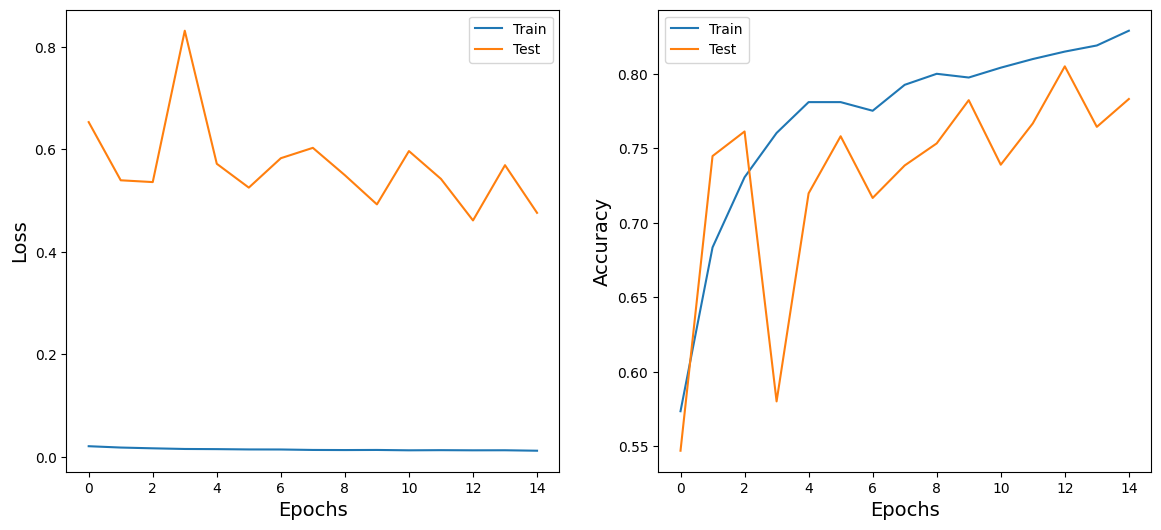

In [78]:
loss_and_acc_plots(gineconv_results)

In [79]:

gat_train_auroc, gat_test_auroc, gat_train_report_df, gat_test_report_df = metric_func(gat_model, train_dataset, test_dataset)
"""
graphconv_train_auroc, graphconv_test_auroc, graphconv_train_report_df, graphconv_test_report_df = metric_func(graphconv_model, train_dataset, test_dataset)

ginconv_train_auroc, ginconv_test_auroc, ginconv_train_report_df, ginconv_test_report_df = metric_func(ginconv_model, train_dataset, test_dataset)
"""
gineconv_train_auroc, gineconv_test_auroc, gineconv_train_report_df, gineconv_test_report_df = metric_func(gineconv_model, train_dataset, test_dataset)



In [80]:
"""
print("GCN results:")
display("train AUC:", train_auroc, "test AUC:", test_auroc, train_report_df, test_report_df)
"""
print("GAT results:")
display("train AUC:", gat_train_auroc, "test AUC:", gat_test_auroc, gat_train_report_df, gat_test_report_df)
"""
print("GraphConv results:")
display("train AUC:", graphconv_train_auroc, "test AUC:", graphconv_test_auroc, graphconv_train_report_df, graphconv_test_report_df)

print("GinConv results:")
display("train AUC:", ginconv_train_auroc, "test AUC:", ginconv_test_auroc, ginconv_train_report_df, ginconv_test_report_df)
"""
print("GineConv results:")
display("train AUC:", gineconv_train_auroc, "test AUC:", gineconv_test_auroc, gineconv_train_report_df, gineconv_test_report_df)

GAT results:


'train AUC:'

0.8536484241485596

'test AUC:'

0.8145527839660645

,precision,recall,f1-score,support
0.0,0.781547,0.868778,0.822857,663.000000
1.0,0.816068,0.705667,0.756863,547.000000
accuracy,0.795041,0.795041,0.795041,0.795041
macro avg,0.798807,0.787223,0.789860,1210.000000
weighted avg,0.797153,0.795041,0.793023,1210.000000


,precision,recall,f1-score,support
0.0,0.702564,0.861635,0.774011,159.000000
1.0,0.796296,0.597222,0.682540,144.000000
accuracy,0.735974,0.735974,0.735974,0.735974
macro avg,0.749430,0.729429,0.728275,303.000000
weighted avg,0.747110,0.735974,0.730540,303.000000


GineConv results:


'train AUC:'

0.9060596823692322

'test AUC:'

0.858490526676178

,precision,recall,f1-score,support
0.0,0.883051,0.785822,0.831604,663.00000
1.0,0.770968,0.873857,0.819195,547.00000
accuracy,0.825620,0.825620,0.825620,0.82562
macro avg,0.827009,0.829840,0.825399,1210.00000
weighted avg,0.832382,0.825620,0.825994,1210.00000


,precision,recall,f1-score,support
0.0,0.800000,0.779874,0.789809,159.000000
1.0,0.763514,0.784722,0.773973,144.000000
accuracy,0.782178,0.782178,0.782178,0.782178
macro avg,0.781757,0.782298,0.781891,303.000000
weighted avg,0.782660,0.782178,0.782283,303.000000
